In [42]:
import numpy as np
import pandas as pd
import re
import spacy
import jsonlines
from spacy import displacy
from spacy.symbols import nsubj, VERB
from spacy.pipeline import EntityRuler
from spacy.matcher import Matcher
from spacy.tokens import Span

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import Counter
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 
from nltk import ngrams

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df2 = pd.read_excel("CVS.xlsx")
df2['len'] = df2['descrição'].str.len()
df2 = df2[df2['len']>100]
cvs = df2['descrição']

In [58]:
df1 = pd.read_excel('LinkedIn Fiscal.xlsx')

df1['len'] = df1['description'].str.len()
df1 = df1[df1['len']>300]

jobs = df1['description']
df1.drop(['Unnamed: 0'],axis=1,inplace=True)
cargos = df1['job']
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 0 to 384
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job          220 non-null    object
 1   description  228 non-null    object
 2   cargo        220 non-null    object
 3   empresa      220 non-null    object
 4   local        220 non-null    object
 5   len          228 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 12.5+ KB


In [22]:
#df1 = pd.read_excel("Catho Analistas controladoria.xlsx")

#df1['len'] = df1['descrição completa'].str.len()
#df1 = df1[df1['len']>300]

#jobs = df1['descrição completa']
#df1.drop(['Unnamed: 0'],axis=1,inplace=True)
#cargos = df1['title']
#df1.info()

In [23]:
class job_skills_parser:

    def __init__(self,nlp):
        nlp=nlp
        config = {"phrase_matcher_attr": None, "validate": True,
                  "overwrite_ents": False, "ent_id_sep": "||", }

        ruler = nlp.add_pipe("entity_ruler", config=config)
        ruler.from_disk('padrões')
        self.rules = ruler.patterns
        
    def update_patterns(self,new_patterns):
        ruler.add_patterns(patterns)
        self.rules = ruler.patterns
        ruler.to_disk('padrões')

    def fit_text(self, text):
        text = text.lower()
        text = text.replace('.', '. ')
        text = text.replace(',', ', ')
        text = text.replace(';', '; ')
        text = text.replace(':', ': ')
        text = text.replace(' . ', ' ')
        text = text.replace('  ', ' ')
        self.doc = nlp(text)

    def show_skills(self):
        displacy.render(self.doc, style="ent", jupyter=True)

    def get_skills(self):
        skills = [(ent.text, ent.label_)
                  for ent in self.doc.ents
                  if ent.label_ in ['JOB_DESC', 'hard_skills', 'formação', 'extra_skills', 'sistemas', 'experiencia']]

        return skills

    def compare_skills(self, text2,filtro='X'):

        patterns_words = [
            'fazer','apuração','apurar','atuação','atuar','realização','realizar','elaoração','elaborar',
            'planejamento','planejar','apoio','apoiar','facilidade','revisão','revisar','execução','executar',
            'análise','analisar','validação','validar','participação','participar','confecção','confeccionar',
            'consolidação','consolidar','desenvolvimento','desenvolver','criação','criar','auxílio','avançado','intermediário'
            'auxiliar','acompanhamento','acompanhar','controle','controlar','revisão','revisar','básico','fluente',
            'formação','formação','formar','graduação','graduar','superior','cursar','cursando','graduação','graduar',
            'vivencia','vivência','atuar','atuação','experiencia','experiência','conhecimento','conhecer','habilidade',
            'capacidade','entendimento','entender','facilidade','avançado','intermediário','intermediario','basico']
        
        stopw = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 'se',
                 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua',
                 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até',
                 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me',
                 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha',
                 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe', 'deles', 'essas',
                 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu',
                 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 
                 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive',
                 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja',
                 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 
                 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 
                 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei',
                 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era',
                 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 
                 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 
                 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos',
                 'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 
                 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']
        
        
        palavras_comuns = [*patterns_words,*stopw]
        disable_palavras_comuns = []
        
        doc2 = nlp(text2)

        try:
            doc1_skills = self.get_skills()
        except:
            raise ValueError('não tem texto1 para fazer a comparação, provavelmente vc esqueceu da parte "fit_text"')

        doc2_skills = [(ent.text, ent.label_) for ent in doc2.ents if ent.label_ in
                       ['JOB_DESC', 'hard_skills', 'formação', 'extra_skills', 'sistemas', 'experiencia']]

        skills_matrix = []

        for sk_doc1, type_doc1 in doc1_skills:
            
            if type_doc1 != filtro:
                sim_ = []
                text_doc1 = ' '.join([w for w in sk_doc1.split() if w not in palavras_comuns])

                for sk_doc2, type_doc2 in doc2_skills:
                    #if type_doc2 == type_doc1:
                    text_doc2 = ' '.join([w.lower() for w in sk_doc2.split() if w not in palavras_comuns])
                    sim = nlp(text_doc1).similarity(nlp(text_doc2))
                    sim_.append(sim)    
                    #else: sim_.append(0)


                try:
                    maxsim = np.array(sim_).argmax()
                    if sim_[maxsim] > .85:
                        skills_matrix.append([type_doc1, sk_doc1, doc2_skills[maxsim][0], sim_[maxsim]])
                    else:
                        skills_matrix.append([type_doc1, sk_doc1, 0, 0])

                except: 
                    skills_matrix.append([type_doc1, sk_doc1, 0, 0])

        try:
            match = np.array([m[3] for m in skills_matrix])
        except:
            total_score = 0
            match = np.array(0)

        return skills_matrix, match.mean()



# Usando o modelo

In [24]:
#carregando o modelo com a inguagem PT large
nlp = spacy.load("pt_core_news_lg")
modelo = job_skills_parser(nlp)

Encontrando skills nos textos.
pipe: 

1) fit_text('texto da vaga ou do currículo',type=string)
   
2) usar as funções para de extração de features (skills)
   a) show_skills: cria um visual destacando os skills encontrados
   b) get_skills: cria uma lista de tuples com as skills encontradas
            
3) vc também pode comparar um texto com outro para ver as similaridades entre os skills encontrados, por exemplo,      comparar uma vaga de emprego com um currículo para ver o quão aderente são. para isso utilize a função comparecompare_skills

In [62]:
#encontrando skills em uma das vagas de emprego da Catho
modelo.fit_text(jobs[125])
modelo.show_skills()
modelo.get_skills()

[('conhecimento em sistema erp', 'hard_skills'),
 ('realizar análises', 'JOB_DESC'),
 ('desenvolver obrigações acessórias e apuração de impostos diretos e indiretos',
  'JOB_DESC'),
 ('elaborar balanços e balancetes e relatórios contábeis', 'JOB_DESC'),
 ('análises de lançamentos e despesas', 'JOB_DESC'),
 ('controle gerencial das contas', 'JOB_DESC'),
 ('apoiar as demais áreas administrativas auxiliando no bom gerenciamento da',
  'JOB_DESC'),
 ('validação e transmissão de obrigações acessórias eletrônicas', 'JOB_DESC'),
 ('validação das informações imputadas no sistema erp', 'JOB_DESC'),
 ('apuração e validação dos tributos', 'JOB_DESC'),
 ('controle de parcelamentos', 'JOB_DESC'),
 ('sistema emissor de notas', 'sistemas')]

In [19]:
#encontrando skills em um dos perfis do LinkedIn
modelo.fit_text(cvs[0])
modelo.show_skills()
modelo.get_skills()

[('sistema sap', 'sistemas'),
 ('controle e organização de documentos', 'JOB_DESC'),
 ('análise de notas fiscais', 'JOB_DESC'),
 ('elaboração de planilhas de custos', 'JOB_DESC')]

In [9]:
cv_fake = 'formação em ciências contábeis, inglês avançado, excel avançado, experiência em controladoria, conhecimento em contabilidade, experiência em demonstrações financeiras, atuando na elaboração de relatórios gerenciais, revisão analítica de balanço patrimonial, conhecimento do setor de energia, experiência em big4, python, DAX, power BI, excel, vba, macros, automatização de processos, elaboração de políticas contábeis,conhecimento em linguagem de programação ,pacote office'

In [27]:
#comparando uma vaga fake com um perfil coletado
#modelo.fit_text('experiência em controladoria, experiencia em contabilidade, formação em ciências contábeis, conhecimento em SAP,inglês intermediário')
modelo.fit_text(jobs[0])
result = modelo.compare_skills(cvs[9],filtro='JOB_DESC')
print(result[1])
pd.DataFrame(result[0])

0.0


,0,1,2,3
0,sistemas,office,0,0
1,hard_skills,entender o ambiente do cliente,0,0
2,formação,graduação em andamento ou completo em,0,0
3,experiencia,experiência com ciências de dados,0,0
4,hard_skills,conhecimento em python,0,0
5,hard_skills,conhecimento em sql,0,0
6,sistemas,pacote,0,0


In [29]:
modelo.fit_text(jobs[29])

for cv in cvs:
    npessoa =+ 1
    resultado = modelo.compare_skills(cv)
    print(npessoa,resultado[1])

1 0.0
1 0.03734237675808799
1 0.0


<ipython-input-23-05968742b849>:94: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim = nlp(text_doc1).similarity(nlp(text_doc2))


1 0.0
1 0.0
1 0.0
1 0.03937234483212391
1 0.0
1 0.03772609618692596
1 0.0
1 0.0
1 0.0
1 0.0


# HeatMap CV x Jobs

In [10]:
#comparando várias vagas com todos os perfis


njob = 0

scores = []

for job in jobs[1:100]:
    njob += 1
    npessoa = 0
    modelo.fit_text(job)
    for cv in cvs:
        npessoa += 1
        resultado = modelo.compare_skills(cv)
        scores.append([njob,npessoa,resultado[1]])

    

<ipython-input-5-05968742b849>:94: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim = nlp(text_doc1).similarity(nlp(text_doc2))


In [11]:
df = pd.DataFrame(scores) 
df = df.rename(columns={0:'Vaga',1:'Perfil',2:'score'}) 
pivot_score = df.pivot_table('score','Vaga','Perfil') 
pivot_score

Perfil,1,2,3,4,5,6,7,8,9,10,11,12,13
Vaga,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.065700,0.076923,0.067637,0.000000,0.0,0.135271,0.067058,0.000000,0.216458,0.000000,0.0,0.000000
3,0.000000,0.102481,0.000000,0.000000,0.000000,0.0,0.157774,0.000000,0.000000,0.050780,0.000000,0.0,0.000000
4,0.088026,0.095200,0.100000,0.000000,0.000000,0.0,0.095200,0.000000,0.089894,0.273738,0.089559,0.0,0.000000
5,0.000000,0.078301,0.000000,0.000000,0.000000,0.0,0.078448,0.000000,0.000000,0.077848,0.000000,0.0,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.121460,0.000000,0.000000,0.000000,0.0,0.369905,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
96,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.122472,0.000000,0.0,0.000000
97,0.146987,0.157223,0.055556,0.048767,0.049391,0.0,0.206943,0.049849,0.048312,0.405810,0.000000,0.0,0.000000


df = pd.DataFrame(scores)
df = df.rename(columns={0:'Vaga',1:'Perfil',2:'score'})
pivot_score = df.pivot_table('score','Vaga','Perfil')
pivot_score

<AxesSubplot:xlabel='Perfil', ylabel='Vaga'>

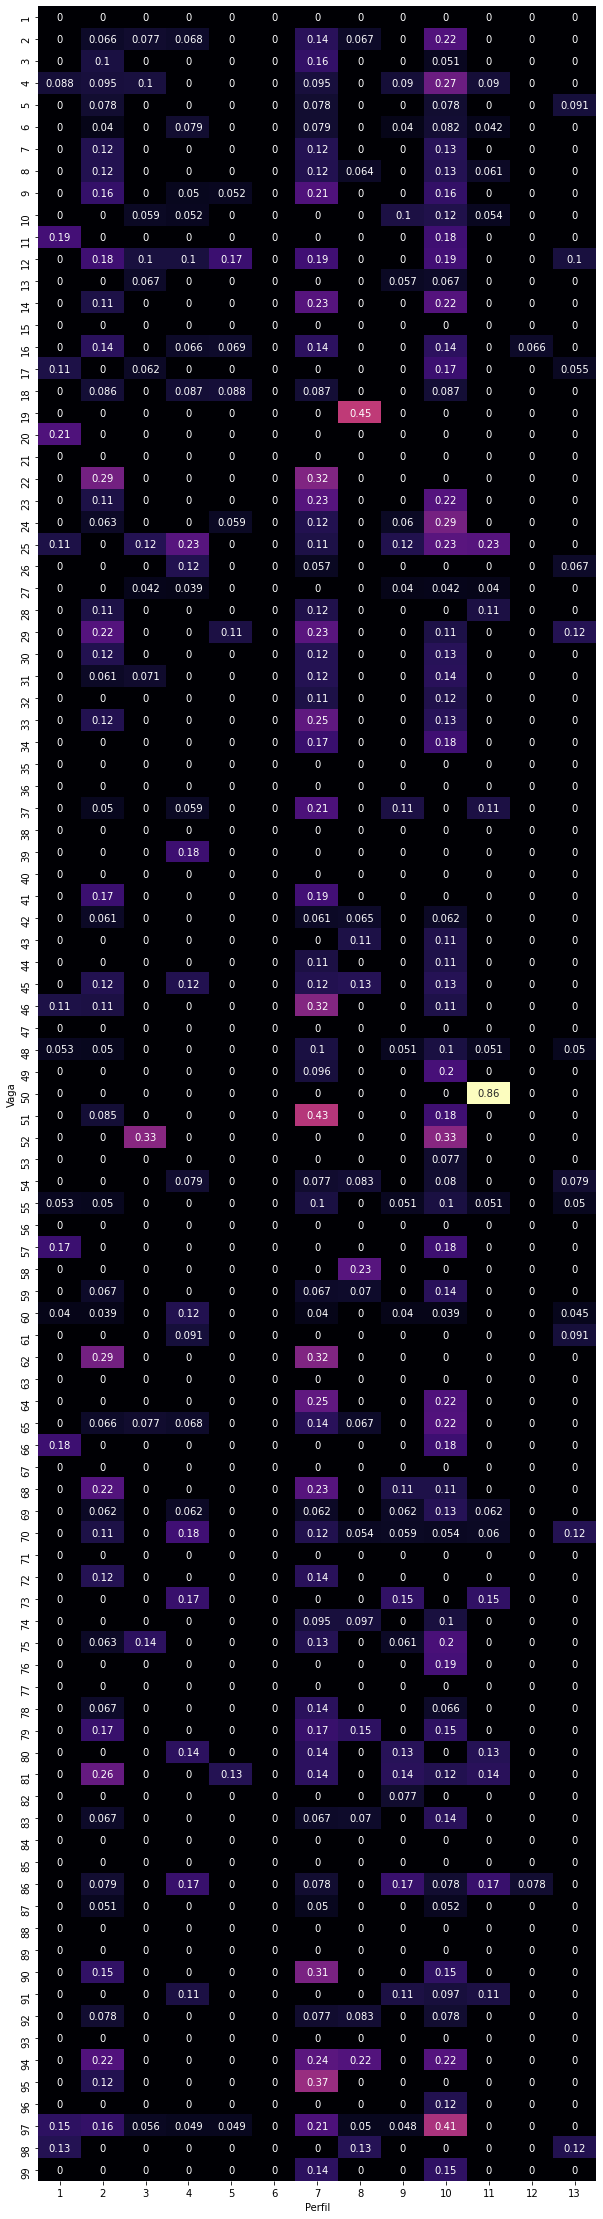

In [29]:
plt.figure(figsize=(10,40))
sns.heatmap(pivot_score,annot=True,cbar=False,cmap="magma")

# TFIDF Analysis

In [72]:
all_skills = {'skills':[],'tipo':[]}

for text in jobs:
    modelo.fit_text(text)
    for skill in modelo.get_skills():
        all_skills['skills'].append(skill[0])
        all_skills['tipo'].append(skill[1])
all_skills = pd.DataFrame(all_skills)

In [73]:
skills = all_skills['skills']

In [74]:
bad_words = ['gender', 'experience', 'application', 'Apply', 'salary', 'todos', 'os', 'company', 'identity', 'sexual', 'orientation',
            'de', 'orientação', 'sexual', 'gênero', 'committed', 'toda', 'client', 'conhecimento',
            'world', 'year', 'save', 'São', 'Paulo', 'information', 'e', 'orientação', 'sexual', 'equal', 'oppotunity', 'ambiente', 'will',
            'Experiência', 'national origin', 'todas', 'work', 'de', 'da', 'years', 'pessoa', 'clients', 'Plano', 'creating',
            'employer', 'saúde', 'em', 'working', 'pessoas', 'mais', 'data', 'people', 'dia', 'one', 'knowledges', 'plataforma',
            'ou', 'benefício', 'para', 'software', 'opportunity', 'tecnologia', 'você', 'mais', 'solution', 'national', 'origin',
            'trabalhar', 'option', 'negócio', 'empresa', 'o', 'sicence', 'team', 'é', 'veteran', 'status', 'etc', 'raça', 'cor', 'belive',
            'nossa', 'uma', 'como', 'Scientist', 'ferramenta', 'projeto', 'que', 'job', 'benefícios', 'knowledge', 'toll', 's', 'modelo',
            'desconto', 'cultura', 'serviço', 'time', 'se', 'solutions', 'mercado', 'das', 'somos', 'problema', 'mundo', 'race', 'color',
            'vaga', 'pelo', 'ser', 'show', 'Seguro', 'Se', 'um', 'Um', 'tool', 'regard', 'without', 'make', 'ao', 'técnica', 'life',
            'interested', 'diversidade', 'proud', 'ability', 'sobre', 'options', 'using', 'área', 'nosso', 'na', 'seu', 'product', 'produto',
            'building', 'skill', 'model', 'religion', 'Share', 'receive', 'consideration', 'Aqui', 'vida', 'ferramentas', 'Vale', 'Refeição',
            'Strong', 'Pay', 'range', 'available', 'part', 'trabalho', 'Alimentação', 'employment', 'qualified', 'applicants', 'gympass',
            'está', 'comprometida', 'forma', 'Transporte', 'Yes', 'gente', 'melhor', 'lugar', 'believe', 'moment', 'próximo', 'deasafio',
            'dos', 'oportunidade', 'idade', 'new', 'Try', 'Premium', 'deficiência', 'sempre', 'criar', 'employee', 'problemas', 'unavailable',
            'Brasil', 'dado', 'hiring', 'trends', 'equipe', 'recent', 'temos', 'build', 'career', 'nós', 'diferencial', 'ma',
            'total', 'oferecemos', 'contato', 'tem', 'não', 'free', 'Full','of','to','is','avançado','conhecimentos',
            'fazer','apuração','apurar','atuação','atuar','realização','realizar','elaoração','elaborar',
            'planejamento','planejar','apoio','apoiar','facilidade','revisão','revisar','execução','executar',
            'análise','analisar','validação','validar','participação','participar','confecção','confeccionar',
            'consolidação','consolidar','desenvolvimento','desenvolver','criação','criar','auxílio','avançado','intermediário'
            'auxiliar','acompanhamento','acompanhar','controle','controlar','revisão','revisar','básico','fluente',
            'formação','formação','formar','graduação','graduar','superior','cursar','cursando','graduação','graduar',
            'vivencia','vivência','atuar','atuação','experiencia','experiência','conhecimento','conhecer','habilidade',
            'capacidade','entendimento','entender','facilidade','avançado','intermediário','intermediario','basico']

stopw = 'de a o que e do da em um para é com não uma os no se na por mais as dos como mas foi ao ele das tem à seu sua ou ser quando muito há nos já está eu também só pelo pela até isso ela entre era depois sem mesmo aos ter seus quem nas me esse eles estão você tinha foram essa num nem suas meu às minha têm numa pelos elas havia seja qual será nós tenho lhe deles essas esses pelas este fosse dele tu te vocês vos lhes meus minhas teu tua teus tuas nosso nossa nossos nossas dela delas esta estes estas aquele aquela aqueles aquelas isto aquilo estou está estamos estão estive esteve estivemos estiveram estava estávamos estavam estivera estivéramos esteja estejamos estejam estivesse estivéssemos estivessem estiver estivermos estiverem hei há havemos hão houve houvemos houveram houvera houvéramos haja hajamos hajam houvesse houvéssemos houvessem houver houvermos houverem houverei houverá houveremos houverão houveria houveríamos houveriam sou somos são era éramos eram fui foi fomos foram fora fôramos seja sejamos sejam fosse fôssemos fossem for formos forem serei será seremos serão seria seríamos seriam tenho tem temos tém tinha tínhamos tinham tive teve tivemos tiveram tivera tivéramos tenha tenhamos tenham tivesse tivéssemos tivessem tiver tivermos tiverem terei terá teremos terão teria teríamos teriam'.split()

stopw = [*stopw,*bad_words]

In [75]:
def word_frequency(sentence,stop_words):
    # joins all the sentenses
    sentence =" ".join(sentence)
    # creates tokens, creates lower class, removes numbers and lemmatizes the words
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stop_words]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
    #counts the words, pairs and trigrams
    counted = Counter(new_tokens)
    counted_2= Counter(ngrams(new_tokens,2))
    counted_3= Counter(ngrams(new_tokens,3))
    #creates 3 data frames and returns thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
    return word_freq,word_pairs,trigrams

In [76]:
wf,wf2,wf3 = word_frequency(skills,stop_words=stopw)
wf['tipo'] = all_skills['tipo']
wf2['tipo'] = all_skills['tipo']
wf3['tipo'] = all_skills['tipo']

<AxesSubplot:xlabel='frequency', ylabel='pairs'>

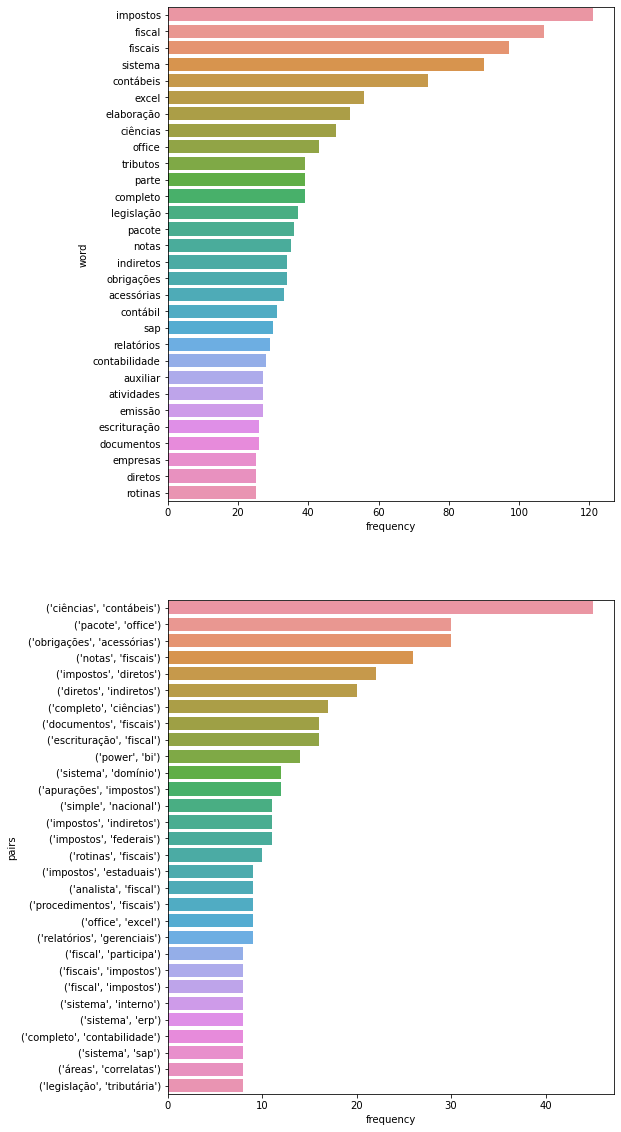

In [77]:
# create subplot of the different data frames
fig, axes = plt.subplots(2,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=wf.head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=wf2.head(30))

In [78]:
def tokenize(text):
    WNLTokens = []
    chars = []
    
    WNLemmatizer = WordNetLemmatizer()
    for ch in text:
        if ch not in string.punctuation:
            chars.append(ch)
        else:
            chars.append(' ')
    txt = ''.join(chars)        
        
    tokens = word_tokenize(txt)
    for t in tokens:
        WNLTokens.append(WNLemmatizer.lemmatize(t))
    
    return WNLTokens

def get_frequency(countvec,sent_list):
    
    dtm = countvec.fit_transform(sent_list)
    word_list = countvec.get_feature_names()

    # Added [0] here to get a 1d-array for iteration by the zip function. 
    count_list = np.asarray(dtm.sum(axis=0))[0]

    word_vec = pd.DataFrame(zip(word_list, count_list))
    word_vec = word_vec.sort_values(1,ascending=False)
    word_vec = word_vec.rename(columns={0:'word',1:'frequency'})
    
    return word_vec

In [79]:
hardskills = all_skills[all_skills['tipo'] == 'hard_skills']['skills']
job_desc = all_skills[all_skills['tipo'] == 'JOB_DESC']['skills']
exp = all_skills[all_skills['tipo'] == 'experiencia']['skills']
sistemas = all_skills[all_skills['tipo'] == 'sistemas']['skills']

In [80]:
ContV = CountVectorizer(max_df=0.95,min_df=3,stop_words=stopw,tokenizer=tokenize,ngram_range=(1, 1))
ContV2 = CountVectorizer(max_df=0.95,min_df=3,stop_words=stopw,tokenizer=tokenize,ngram_range=(2, 2))


In [81]:
hardskills_cv = get_frequency(ContV,hardskills)
job_desc_cv = get_frequency(ContV,job_desc)
exp_cv = get_frequency(ContV,exp)
sistemas_cv = get_frequency(ContV,sistemas)

hardskills_cv2 = get_frequency(ContV2,hardskills)
job_desc_cv2 = get_frequency(ContV2,job_desc)
exp_cv2 = get_frequency(ContV2,exp)
sistemas_cv2 = get_frequency(ContV2,sistemas)

C:\Users\a92550\AppData\Roaming\Python\Python38\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['alimentação', 'applicant', 'apply', 'aqui', 'brasil', 'es', 'forum', 'full', 'paulo', 'pay', 'plano', 'premium', 'refeição', 'scientist', 'seguro', 'share', 'strong', 'transporte', 'trend', 'try', 'vale', 'yes'] not in stop_words.
  warnings.warn(
C:\Users\a92550\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Experience pairs')

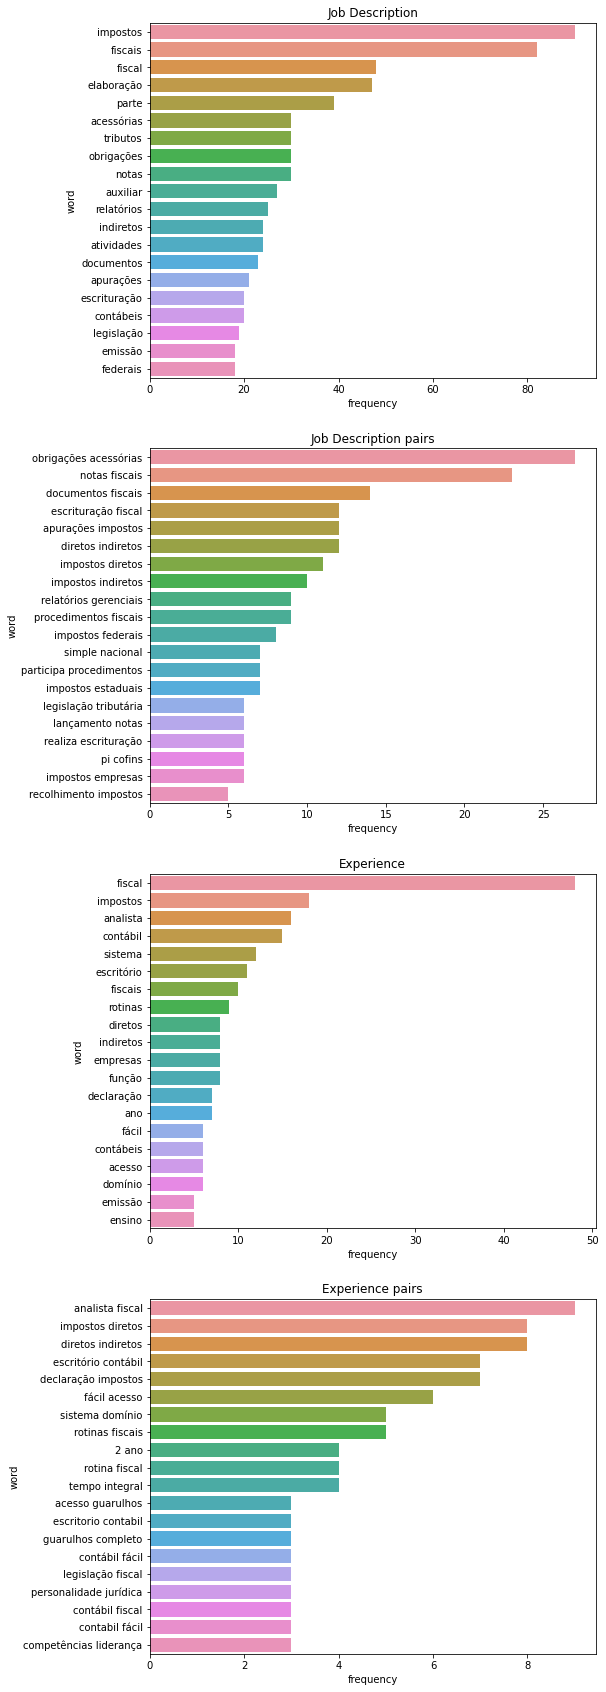

In [82]:
fig, axes = plt.subplots(4,1,figsize=(8,30))

sns.barplot(ax=axes[0],x='frequency',y='word',data=job_desc_cv.head(20)).set_title('Job Description')
sns.barplot(ax=axes[1],x='frequency',y='word',data=job_desc_cv2.head(20)).set_title('Job Description pairs')
sns.barplot(ax=axes[2],x='frequency',y='word',data=exp_cv.head(20)).set_title('Experience')
sns.barplot(ax=axes[3],x='frequency',y='word',data=exp_cv2.head(20)).set_title('Experience pairs')


Text(0.5, 1.0, 'Sistemas pairs')

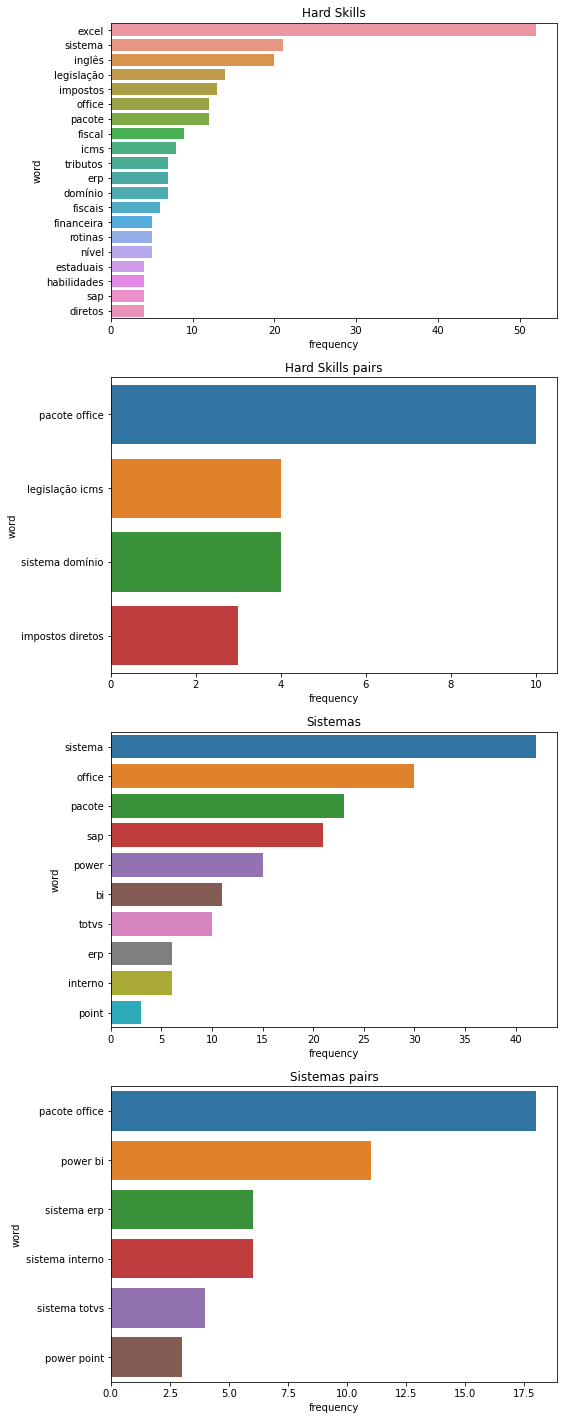

In [83]:
fig, axes = plt.subplots(4,1,figsize=(8,25))

sns.barplot(ax=axes[0],x='frequency',y='word',data=hardskills_cv.head(20)).set_title('Hard Skills')
sns.barplot(ax=axes[1],x='frequency',y='word',data=hardskills_cv2.head(20)).set_title('Hard Skills pairs')
sns.barplot(ax=axes[2],x='frequency',y='word',data=sistemas_cv.head(20)).set_title('Sistemas')
sns.barplot(ax=axes[3],x='frequency',y='word',data=sistemas_cv2.head(20)).set_title('Sistemas pairs')

In [55]:
#df = pd.DataFrame(all_skills)
#df.to_excel('Skills_linkedin.xlsx')


# Calibrar os padrões

In [95]:
patterns = [{'label': 'JOB_DESC',
  'pattern': [{'LEMMA': {'IN': [
      'fazer',
      'apuração','apurar',
      'atuação','atuar',
      'realização','realizar',
      'elaboração','elaborar',
      'planejamento','planejar',
      'apoio','apoiar',
      'facilidade',
      'revisão','revisar',
      'execução','executar',
      'análise','analisar',
      'validação','validar',
      'participação','participar',
      'confecção','confeccionar',
      'consolidação','consolidar',
      'desenvolvimento','desenvolver',
      'criação','criar',
      'auxílio','auxiliar',
      'acompanhamento','acompanhar',
      'controle','controlar','controlo',
      'revisão','revisar'
      ]}},
   {'POS': {'IN': ['VERB', 'ADP', 'DET','NOUN', 'ADJ','ADV', 'PROPN','CCONJ',]},'OP': '+'}
             ]},
            
            
 {'label': 'formação',
  'pattern': [{'LEMMA': {'IN': ['formação',
      'formação','formar',
      'graduação','graduar',
      'superior',
      'cursar','cursando',
      'graduação','graduar'
      ]}},
   {'LOWER': {'IN': [
       'superior',
      'completo',''
      'cursando',
      'graduação',
      ]},
    'OP': '*'},
   {'POS': 'ADP'},
   {'POS': {'IN': ['VERB', 'ADP', 'DET', 'NOUN', 'ADJ', 'PROPN', 'CCONJ']},
    'OP': '+'}]},
            
            
 {'label': 'experiencia',
  'pattern': [{'LEMMA': {'IN': [
      'vivencia','vivência',
      'atuar','atuação',
      'experiencia','experiência'
        ]}},              
   {'POS': {'IN': ['ADP', 'DET']}},
   {'POS': {'IN': ['VERB', 'ADP', 'DET', 'NOUN', 'ADJ', 'PROPN', 'NUM','CCONJ']},
    'OP': '+'}]},
            
 {'label': 'hard_skills',
  'pattern': [{'LEMMA': {'IN': [
      'conhecimento','conhecer',
      'habilidade',
      'capacidade',
      'entendimento','entender',
      'facilidade'
        ]}},
   {'POS': {'IN': ['ADP', 'DET']}},
   {'POS': {'IN': ['VERB', 'ADP', 'DET', 'NOUN', 'ADJ', 'PROPN', 'NUM']},
    'OP': '+'}]},
            
            
 {'label': 'hard_skills',
  'pattern': [{'IS_PUNCT': False},
   {'LOWER': {'IN': [
      'avançado',
      'intermediário',
      'intermediario',
      'basico',
      'básico',
      'fluente'
   ]}},
   {'POS': {'IN': ['VERB', 'ADP', 'DET', 'NOUN', 'ADJ', 'PROPN']},
    'OP': '*'}]},
            
            
 {'label': 'sistemas',
  'pattern': [{'LOWER': {'IN': ['power',
      'PBI',
      'powerbi',
      'sap',
      'totvs',
      'tableau',
      'pacote',
      'hyperion',
      'office',
            ]}},  
   {'LOWER': {'IN': ['bi',
      'powerbi',
      'sap',
      'totvs',
      'tableau',
      'office',
      'point',
      'query']},
    'OP': '*'}]},
            
 {'label': 'sistemas',
  'pattern': [{'LOWER': 'sistema'},
   {'POS': {'IN': ['VERB', 'ADP', 'NOUN', 'ADJ', 'PROPN']}, 'OP': '+'}]},

            
 {'label': 'Linguagens',
  'pattern': [{'LOWER': {'IN': [

    'DAX'
    'python',
    'vba',
    'macro',
    'sql',
    'JavaScript',
    'Java',
    'c#',
    'c++',
    'PHP',
    'Ruby',
    'CSS',
    'TypeScript',
    'Swift',
    'Objective-C',
    'Scala',
    'R',
    'Go',
    'Shell',
    'PowerShell',
    'Perl',
    'Kotlin',
    'Haskell'      
  ]}}  
   ]}]





In [96]:
nlp = spacy.load("pt_core_news_lg")
nlp=nlp
config = {"phrase_matcher_attr": None, "validate": True,
                  "overwrite_ents": False, "ent_id_sep": "||", }

ruler = nlp.add_pipe("entity_ruler", config=config)
ruler.add_patterns(patterns)
ruler.to_disk('padrões')

Preprocessing for the model